In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns
from sklearn.metrics import mean_squared_error
from math import sqrt
import statistics
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX 
import pmdarima as pm
from pmdarima.arima import ndiffs

# for geoplotting
# import geopandas as gpd
# import geoplot as gpl
# import geoplot.crs as gcrs
# from shapely.geometry import Point

In [2]:
df = pd.read_csv("train.csv")
df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.795837,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,NaN,NaN,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.000079,0.676296,-0.000048,0.121164,4.121269,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [3]:
df.shape

(79023, 76)

In [4]:
# Unique values of latitudes and longitudes
print("latitudes:", len(set(df["latitude"])), "longitudes:", len(set(df["longitude"])))

latitudes: 452 longitudes: 453


In [5]:
# Checking the number of unique locations in the data set
unique_latlongs = df.drop_duplicates(subset = ["latitude", "longitude"])
print(unique_latlongs.iloc[:, :4])

print("Total rows of data=", len(unique_latlongs) * 159)

           ID_LAT_LON_YEAR_WEEK  latitude  longitude  year
0      ID_-0.510_29.290_2019_00    -0.510     29.290  2019
159    ID_-0.528_29.472_2019_00    -0.528     29.472  2019
318    ID_-0.547_29.653_2019_00    -0.547     29.653  2019
477    ID_-0.569_30.031_2019_00    -0.569     30.031  2019
636    ID_-0.598_29.102_2019_00    -0.598     29.102  2019
...                         ...       ...        ...   ...
78228  ID_-3.153_30.347_2019_00    -3.153     30.347  2019
78387  ID_-3.161_28.839_2019_00    -3.161     28.839  2019
78546  ID_-3.174_29.926_2019_00    -3.174     29.926  2019
78705  ID_-3.287_29.713_2019_00    -3.287     29.713  2019
78864  ID_-3.299_30.301_2019_00    -3.299     30.301  2019

[497 rows x 4 columns]
Total rows of data= 79023


In [6]:
# Make a location column in this form: "latitude_longitude"
df["location_id"] = df["latitude"].astype(str) + '_' + df["longitude"].astype(str)
df["date"] = df["year"].astype(str) + '_' + df["week_no"].astype(str)

# Rearrange columns
columns = list(df.columns)
columns.insert(5, columns.pop(columns.index('location_id'))) # columns.pop(columns.index('location_id') contains the string "location_id"
columns.insert(6, columns.pop(columns.index('date')))
df = df[columns]

In [7]:
df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,location_id,date,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.51_29.29,2019_0,-0.000108,0.603019,-0.000065,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,-0.51_29.29,2019_1,0.000021,0.728214,0.000014,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,-0.51_29.29,2019_2,0.000514,0.748199,0.000385,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.51,29.29,2019,3,-0.51_29.29,2019_3,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.51,29.29,2019,4,-0.51_29.29,2019_4,-0.000079,0.676296,-0.000048,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317


In [8]:
type(df["year"][0])

numpy.int64

In [9]:
# Missing values per column
na_counts = df.isna().sum()
for index, count in na_counts.items():
    print(index, count)

ID_LAT_LON_YEAR_WEEK 0
latitude 0
longitude 0
year 0
week_no 0
location_id 0
date 0
SulphurDioxide_SO2_column_number_density 14609
SulphurDioxide_SO2_column_number_density_amf 14609
SulphurDioxide_SO2_slant_column_number_density 14609
SulphurDioxide_cloud_fraction 14609
SulphurDioxide_sensor_azimuth_angle 14609
SulphurDioxide_sensor_zenith_angle 14609
SulphurDioxide_solar_azimuth_angle 14609
SulphurDioxide_solar_zenith_angle 14609
SulphurDioxide_SO2_column_number_density_15km 14609
CarbonMonoxide_CO_column_number_density 2122
CarbonMonoxide_H2O_column_number_density 2122
CarbonMonoxide_cloud_height 2122
CarbonMonoxide_sensor_altitude 2122
CarbonMonoxide_sensor_azimuth_angle 2122
CarbonMonoxide_sensor_zenith_angle 2122
CarbonMonoxide_solar_azimuth_angle 2122
CarbonMonoxide_solar_zenith_angle 2122
NitrogenDioxide_NO2_column_number_density 18320
NitrogenDioxide_tropospheric_NO2_column_number_density 18320
NitrogenDioxide_stratospheric_NO2_column_number_density 18320
NitrogenDioxide_NO2_sl

#### Emissions EDA

In [10]:
print("Range of emission values")
print("Emission min:", df["emission"].min())
print("Emission max:", df["emission"].max())

Range of emission values
Emission min: 0.0
Emission max: 3167.768


In [11]:
df["emission"].describe()

count    79023.000000
mean        81.940552
std        144.299648
min          0.000000
25%          9.797995
50%         45.593445
75%        109.549595
max       3167.768000
Name: emission, dtype: float64

In [12]:
# High emission indices
high_emissions_df = df.loc[df["emission"] > 2000]
high_emissions_df.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,location_id,date,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
46587,ID_-2.079_29.321_2019_00,-2.079,29.321,2019,0,-2.079_29.321,2019_0,NaN,NaN,NaN,...,2620.128453,68139.833964,1856.415641,32.131939,0.239269,-41.171539,29.888111,-133.322392,31.588696,2778.1920
46588,ID_-2.079_29.321_2019_01,-2.079,29.321,2019,1,-2.079_29.321,2019_1,NaN,NaN,NaN,...,3936.692103,58517.607479,2926.521405,34.762639,0.253798,44.984207,40.190883,-143.739903,25.914405,2950.9507
46589,ID_-2.079_29.321_2019_02,-2.079,29.321,2019,2,-2.079_29.321,2019_2,0.000159,0.741044,0.000118,...,4490.770188,53755.163592,3443.213782,19.929754,0.261905,15.449158,30.402736,-140.554126,25.307976,3093.1740
46590,ID_-2.079_29.321_2019_03,-2.079,29.321,2019,3,-2.079_29.321,2019_3,0.000322,0.682432,0.000215,...,5830.669775,47789.731655,4831.351318,15.753355,0.265051,-12.708137,37.690640,-135.281579,26.302885,3136.0488
46591,ID_-2.079_29.321_2019_04,-2.079,29.321,2019,4,-2.079_29.321,2019_4,0.000042,0.779578,0.000029,...,4280.978893,55349.706102,3230.417142,8.344532,0.261588,73.571106,46.080676,-142.490367,19.759141,3131.8489


In [13]:
# Emission max index
df.loc[df["emission"] == df["emission"].max()]

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,location_id,date,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
46592,ID_-2.079_29.321_2019_05,-2.079,29.321,2019,5,-2.079_29.321,2019_5,-0.000024,0.722607,-0.000021,...,5130.179853,50528.287051,4074.340447,10.763899,0.26994,30.211407,36.954013,-134.640866,20.354112,3167.768


In [14]:
# Emission min indices
min_emissions_df = df.loc[df["emission"] == df["emission"].min()]
min_emissions_df["year"].value_counts()

year
2019    795
2020    795
2021    795
Name: count, dtype: int64

In [15]:
min_emissions_df["location_id"].value_counts()

location_id
-1.328_28.872    159
-1.505_30.995    159
-1.532_28.568    159
-1.682_29.218    159
-1.696_28.304    159
-1.712_28.688    159
-1.73_28.47      159
-1.833_28.467    159
-1.839_28.761    159
-1.974_28.526    159
-2.496_28.504    159
-2.817_29.283    159
-2.841_29.159    159
-2.859_29.041    159
-2.898_29.002    159
Name: count, dtype: int64

#### There are 15 locations where carbon emission is 0 for all 53 weeks in each year: 2019, 2020, 2021. 

In [16]:
# Take the average emission per year_week for each location
avg_emissions_by_year_week = df.groupby(["year", "week_no"])["emission"].mean()
avg_emissions_by_year_week = pd.DataFrame(avg_emissions_by_year_week)
avg_emissions_by_year_week = avg_emissions_by_year_week.reset_index() # reset the index to extract year and week_no as named columns in the df
avg_emissions_by_year_week.head(10)

,year,week_no,emission
0,2019,0,76.739149
1,2019,1,82.376350
2,2019,2,86.008823
3,2019,3,87.903964
4,2019,4,89.595095
5,2019,5,88.912221
6,2019,6,88.946225
7,2019,7,87.610861
8,2019,8,88.452825
9,2019,9,85.506757


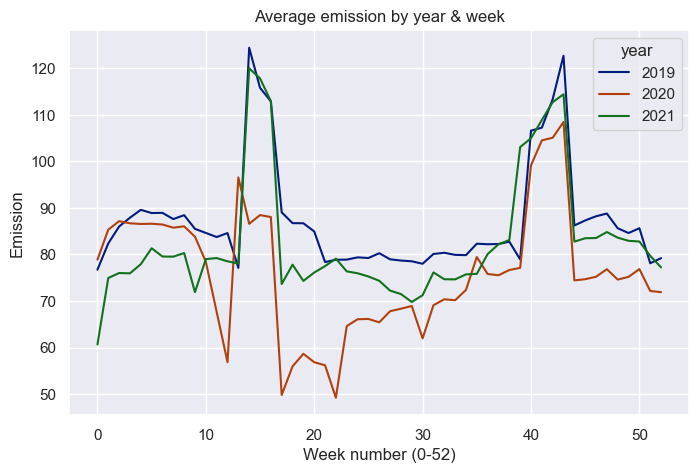

In [17]:
sns.set_theme(rc={'figure.figsize':(8, 5)}) 
sns.lineplot(data = avg_emissions_by_year_week, x = "week_no", y = "emission", hue = "year", palette='dark').set(xlabel = "Week number (0-52)", ylabel = "Emission", title='Average emission by year & week');

It looks like there is some seasonality in emission because emissions tend to be high between weeks 10 and 20, and between weeks ~38 and 45. The time series data does not seem to be trending because for all three years, emission levels have mostly stayed between 60 and 90 units, with the exception of the historic low in 2020 and the peaks in between weeks 10-20 and weeks ~38-45.

In [18]:
## The following code calculates the Ft and Fs (measure strength of trend and seasonality)
## The closer Ft and Fs values are to 1, the stronger the seasonality and trend strengths are. 

data = avg_emissions_by_year_week["emission"]
# Perform STL decomposition
stl = STL(data, period = 53)  # Adjust period as needed for your data
result = stl.fit()

# Extract components
trend = result.trend
seasonal = result.seasonal
residual = result.resid
t_and_r = trend + residual

# Ensure all series are aligned
if not trend.empty and not residual.empty and not seasonal.empty:
    # Calculate Trend Strength
    var_residual = residual.var()
    var_t_plus_r = t_and_r.var()
    var_detrended = (data - trend).var()
    if var_detrended == 0:
        trend_strength = 0
        print("Trend Strength: 0 (Detrended variance is zero)")
    else:
        trend_strength = 1 - (var_residual / var_t_plus_r)
        trend_strength = max(0, trend_strength)  # Avoid negative strength
        print(f"Trend Strength: {trend_strength:.2f}")
    # Calculate Seasonal Strength
    var_seasonal = seasonal.var()
    if var_detrended == 0:
        seasonal_strength = 0
        print("Seasonal Strength: 0 (Detrended variance is zero)")
    else:
        seasonal_strength = var_seasonal / var_detrended
        seasonal_strength = max(0, seasonal_strength)  # Avoid negative strength
        print(f"Seasonal Strength: {seasonal_strength:.2f}")
else:
    print("Trend, Seasonal, or Residual series is empty or misaligned.")

Trend Strength: 0.58
Seasonal Strength: 0.85


#### Find correlation

In [19]:
correlation_subsetdf = df.iloc[:, 7:].corr()

# Ten variables that are most highly correlated with emission
top10_corrs = abs(correlation_subsetdf['emission']).sort_values(ascending = False).head(10)
top10_corrs

emission                                                    1.000000
UvAerosolLayerHeight_aerosol_height                         0.069008
UvAerosolLayerHeight_aerosol_pressure                       0.068138
Cloud_surface_albedo                                        0.046587
CarbonMonoxide_H2O_column_number_density                    0.043217
CarbonMonoxide_CO_column_number_density                     0.041328
Formaldehyde_tropospheric_HCHO_column_number_density_amf    0.040263
UvAerosolLayerHeight_aerosol_optical_depth                  0.040156
UvAerosolLayerHeight_sensor_azimuth_angle                   0.035142
NitrogenDioxide_solar_azimuth_angle                         0.033417
Name: emission, dtype: float64

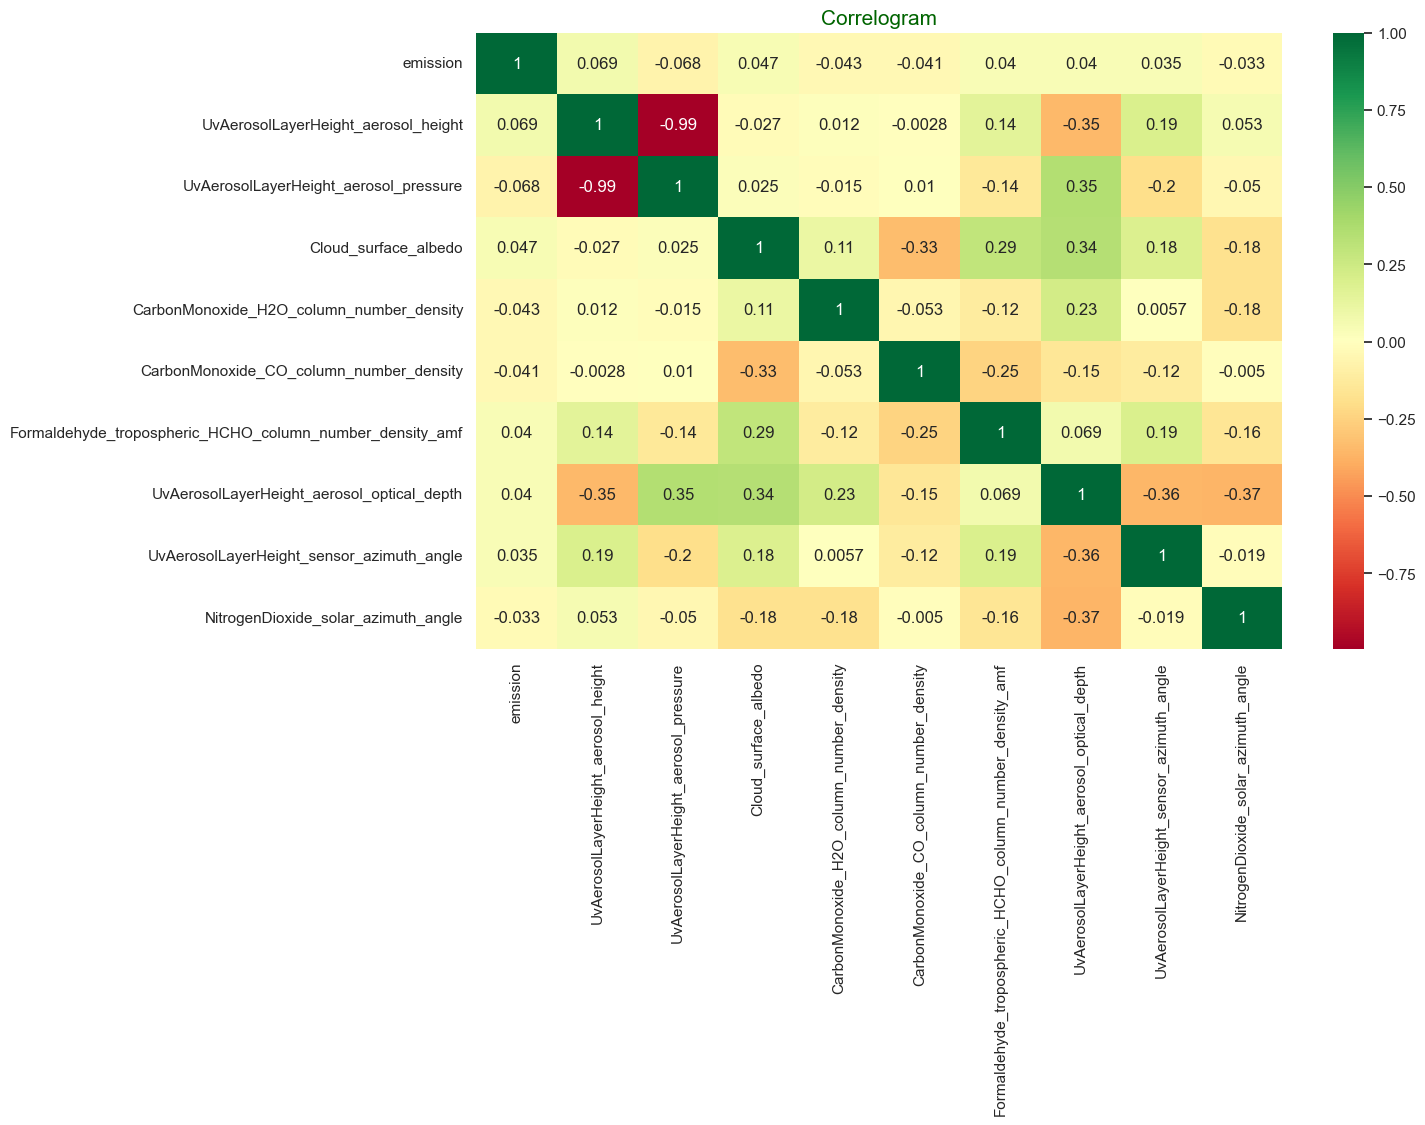

In [20]:
# Create a heatmap displaying correlation between features
corr = df[list(top10_corrs.index)].corr() 
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

We do not see a lot of correlation among features that have the highest correlation to emission. 

#### Modeling

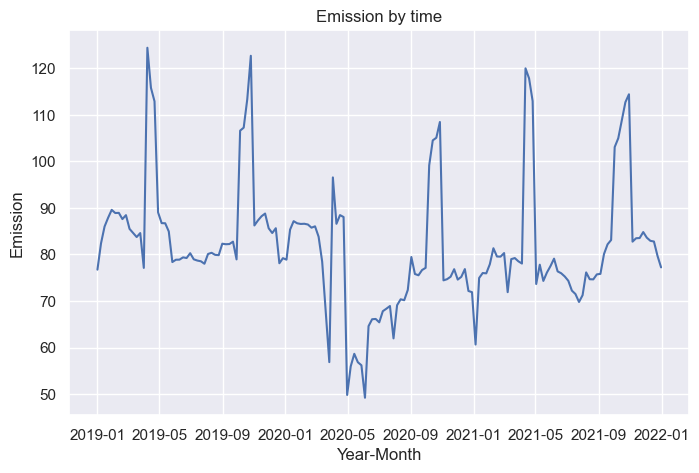

In [21]:
# Checking for seasonality
dates = pd.date_range(start = '2019-01-01', end = '2021-12-31', periods = 159)
avg_emissions_by_year_week.index = pd.to_datetime(dates)
plt.plot(avg_emissions_by_year_week['emission'])
plt.xlabel("Year-Month")
plt.ylabel("Emission")
plt.title("Emission by time")
plt.show()

In [22]:
avg_emissions_by_year_week.head()

,year,week_no,emission
2019-01-01 00:00:00.000000000,2019,0,76.739149
2019-01-07 22:19:44.810126582,2019,1,82.376350
2019-01-14 20:39:29.620253164,2019,2,86.008823
2019-01-21 18:59:14.430379746,2019,3,87.903964
2019-01-28 17:18:59.240506329,2019,4,89.595095


Emission data seems to have a seasonality every 4 months (the distance between each peaks). So I will calculate the number of weeks in 5 months to find out what to set my period to when I do sesonal decomposition. Since a month typically has about 4.33 weeks, I multiply this by 4 to get the period: 4.33 * 4 = 17.32 (round down to 17).

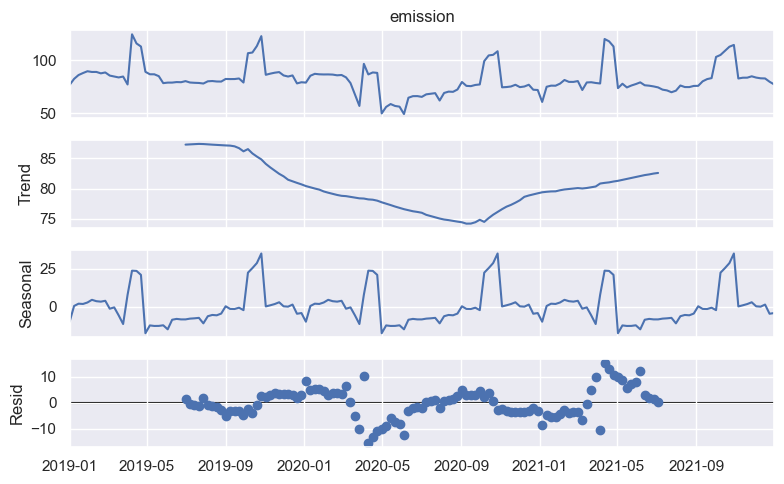

In [23]:
result = seasonal_decompose(avg_emissions_by_year_week["emission"], model = 'additive', period = 53)
result.plot()
pyplot.show()

In [24]:
# Checked for multiplicative seasonality but the errors are not centered on 0.
# result_mul = seasonal_decompose(avg_emissions_by_year_week["emission"], model = 'multiplicative', period = 17)
# result_mul.plot()
# pyplot.show()

#### Baseline model: Holt Winters Exponential Smoothing model 

In [25]:
# Need to redefine the avg_emissions_by_year_week to have generic indices instead of a date index
avg_emissions_by_year_week = df.groupby(["year", "week_no"])["emission"].mean()
avg_emissions_by_year_week = pd.DataFrame(avg_emissions_by_year_week)
avg_emissions_by_year_week = avg_emissions_by_year_week.reset_index() # reset the index to extract year and week_no as named columns in the df

In [26]:
# Train-test split
train = avg_emissions_by_year_week.head(len(avg_emissions_by_year_week) - 49) # because we have to predict 49 weeks out per location
test = avg_emissions_by_year_week.tail(49)

In [27]:
len(train)

110

#### Check for AIC and BIC to choose a seasonal period

In [28]:
seasonality_2months_aic = ExponentialSmoothing(train['emission'], seasonal='add', seasonal_periods = 10).fit().aic
seasonality_3months_aic = ExponentialSmoothing(train['emission'], seasonal='add', seasonal_periods = 13).fit().aic
seasonality_4months_aic = ExponentialSmoothing(train['emission'], seasonal='add', seasonal_periods = 17).fit().aic
seasonality_5months_aic = ExponentialSmoothing(train['emission'], seasonal='add', seasonal_periods = 21).fit().aic
seasonality_12months_aic = ExponentialSmoothing(train['emission'], seasonal='add', seasonal_periods = 53).fit().aic

print("AIC comparisons")
print("seasonality_2months", seasonality_2months_aic)
print("seasonality_3months", seasonality_3months_aic)
print("seasonality_4months", seasonality_4months_aic)
print("seasonality_5months", seasonality_5months_aic)
print("seasonality_12months", seasonality_12months_aic)

AIC comparisons
seasonality_2months 525.3162445576864
seasonality_3months 504.56290319093046
seasonality_4months 524.4583366998827
seasonality_5months 533.6524954077694
seasonality_12months 437.69182663749115


In [29]:
seasonality_2months_bic = ExponentialSmoothing(train['emission'], seasonal='add', seasonal_periods = 10).fit().bic
seasonality_3months_bic = ExponentialSmoothing(train['emission'], seasonal='add', seasonal_periods = 13).fit().bic
seasonality_4months_bic = ExponentialSmoothing(train['emission'], seasonal='add', seasonal_periods = 17).fit().bic
seasonality_5months_bic = ExponentialSmoothing(train['emission'], seasonal='add', seasonal_periods = 21).fit().bic
seasonality_12months_bic = ExponentialSmoothing(train['emission'], seasonal='add', seasonal_periods = 53).fit().bic

print("BIC comparisons")
print("seasonality_2months", seasonality_2months_bic)
print("seasonality_3months", seasonality_3months_bic)
print("seasonality_4months", seasonality_4months_bic)
print("seasonality_5months", seasonality_5months_bic)
print("seasonality_12months", seasonality_12months_bic)

BIC comparisons
seasonality_2months 557.7220089471955
seasonality_3months 545.0701086778167
seasonality_4months 575.7674636499387
seasonality_5months 595.763543820995
seasonality_12months 586.218246756074


C:\Users\chery\AppData\Local\Temp\ipykernel_6808\193941705.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['HWES_ADD'] = ExponentialSmoothing(train['emission'], seasonal='add', seasonal_periods = 53).fit().fittedvalues # yearly seasonality, Holt Winter’s Exponential Smoothing


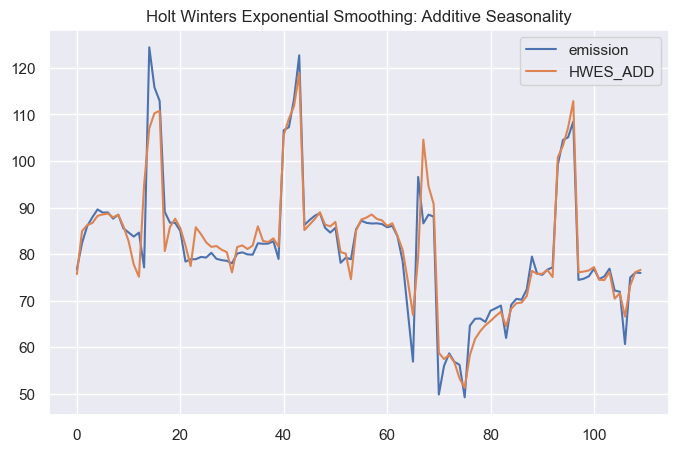

In [30]:
# ESM modeling on train data (can be taken out)
train['HWES_ADD'] = ExponentialSmoothing(train['emission'], seasonal='add', seasonal_periods = 53).fit().fittedvalues # yearly seasonality, Holt Winter’s Exponential Smoothing
train[['emission', 'HWES_ADD']].plot(title='Holt Winters Exponential Smoothing: Additive Seasonality')
plt.show()

In [31]:
# ESM model
fit_esm = ExponentialSmoothing(train['emission'], seasonal='add', seasonal_periods = 53).fit()

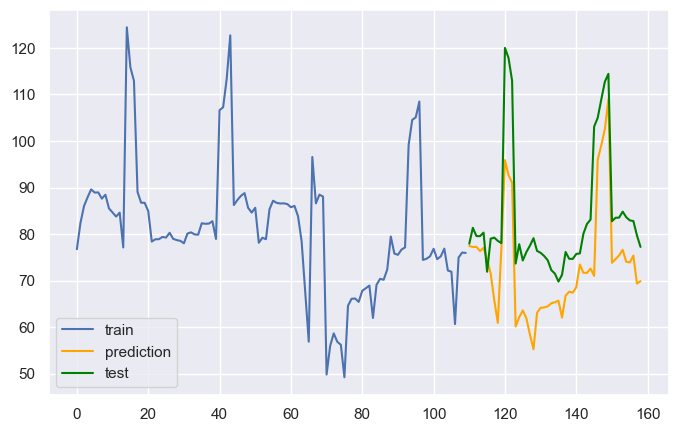

In [32]:
# Forecasting
fcast_esm = fit_esm.forecast(49)
ax = train["emission"].plot(figsize = (8, 5), label = "train")
fcast_esm.plot(ax = ax, color = "orange", label = "prediction")
plt.plot([x+110 for x in range(len(test["emission"]))], test["emission"], label = "test", color = "green") # We have 110 weeks in train data.
plt.legend()
plt.show()

In [33]:
rmse_esm = sqrt(mean_squared_error(test['emission'], fcast_esm))
rmse_esm

12.178371273312727

#### Model 2: Seasonal ARIMA

#### Unit-Root Test using Augmented Dickey-Fuller test

In [34]:
# Calculate the difference between the current value and the value one season (53 periods) ago
train["emission_diff"] = train["emission"] - train["emission"].shift(53)
result = adfuller(train["emission_diff"].dropna(), autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'number of lags: {result[2]}')

ADF Statistic: -2.0095416575296077
p-value: 0.2824051498478613
number of lags: 2


C:\Users\chery\AppData\Local\Temp\ipykernel_6808\3152939943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["emission_diff"] = train["emission"] - train["emission"].shift(53)


In [35]:
# how many differencing steps are needed for stationarity?
print("Number of differences needed for stationarity:", ndiffs(train["emission"], test='adf'))

Number of differences needed for stationarity: 1


We keep the null hypothesis of the Augmented Dickey-Fuller test and conclude that the time series is non-stationary, and a unit root exists for our time series. This means we have a random walk time series and need to do differencing (will have to model AR and MA terms on the differences). 

We also need to do Canova-Hansen test to check if our time series has a deterministic or a stochastic seasonality. If deterministic, it means the seasonal pattern is stable over time. But the Canova-Hansen test is best used for time series with fewer than 12-24 periods in a season. In our data, we have 53 periods in a season. So, best to just approach with a deterministic solution. This will make our data stationary. Once stationary, we can model with traditional ARIMA approaches.

10/18/2024: Proceed with deterministic solution - seasonal dummy variables? 

#### Addressing seasonality: Deterministic solution using seasonal dummy variables

In [36]:
# Train-test split (ds stands for deterministic seasonality)
train_ds = avg_emissions_by_year_week.head(len(avg_emissions_by_year_week) - 49) # because we have to predict 49 weeks out per location
test_ds = avg_emissions_by_year_week.tail(49)

In [37]:
train_ds.head()

,year,week_no,emission
0,2019,0,76.739149
1,2019,1,82.376350
2,2019,2,86.008823
3,2019,3,87.903964
4,2019,4,89.595095


In [38]:
results = sm.OLS.from_formula("emission ~ C(week_no)", data = train_ds).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               emission   R-squared:                       0.662
Model:                            OLS   Adj. R-squared:                  0.353
Method:                 Least Squares   F-statistic:                     2.144
Date:                Mon, 18 Nov 2024   Prob (F-statistic):            0.00266
Time:                        18:43:33   Log-Likelihood:                -383.48
No. Observations:                 110   AIC:                             873.0
Df Residuals:                      57   BIC:                             1016.
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           72.0880      6.338  

In [39]:
results.resid

0       4.651146
1       1.490577
2       2.947459
3       4.386260
4       1.516117
         ...    
105    -3.654629
106   -11.449709
107    -5.939170
108    -7.047406
109    -7.573513
Length: 110, dtype: float64

In [40]:
auto_arima_model = pm.auto_arima(results.resid.dropna(), start_p = 0, start_q = 0, max_p = 5, max_q = 5, seasonal = False) # m refers to the number of periods in each season. seasonal=False because we have already removed the impact of the season from our dataset.
                    # We first build a linear regression and then evaluate which ARIMA model we need on the residuals from our model. 
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(2, 1, 0)   Log Likelihood                -311.477
Date:                Mon, 18 Nov 2024   AIC                            628.954
Time:                        18:43:34   BIC                            637.028
Sample:                             0   HQIC                           632.228
                                - 110                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8241      0.046    -18.014      0.000      -0.914      -0.734
ar.L2         -0.4107      0.059     -6.983      0.000      -0.526      -0.295
sigma2        17.6383      1.601     11.017      0.000      14.500      20.776
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                90.22
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### The auto_arima function suggests a Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors (SARIMAX) model with 2 AR terms, 1 differencing, and 0 MA terms.
If we have an ARIMA(0,0,0)(2,1,0)53 model, we would expect the ACF plot to have an exponentially decreasing pattern every 53 lags while the PACF only had a single spike at lag 53. 

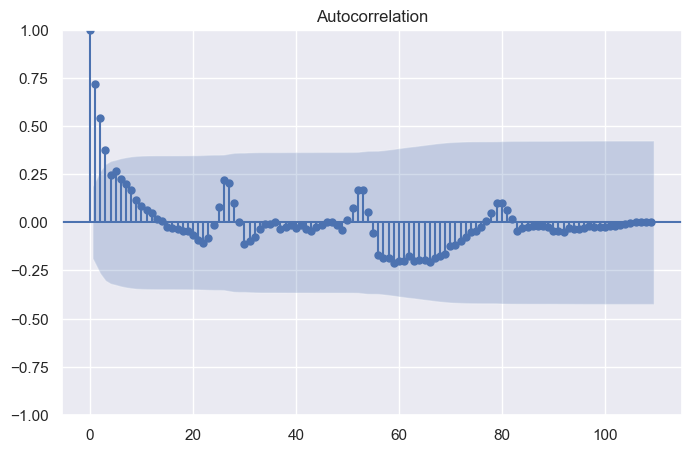

In [41]:
plot_acf(train_ds['emission'].dropna(), lags = 109) 
pyplot.show()

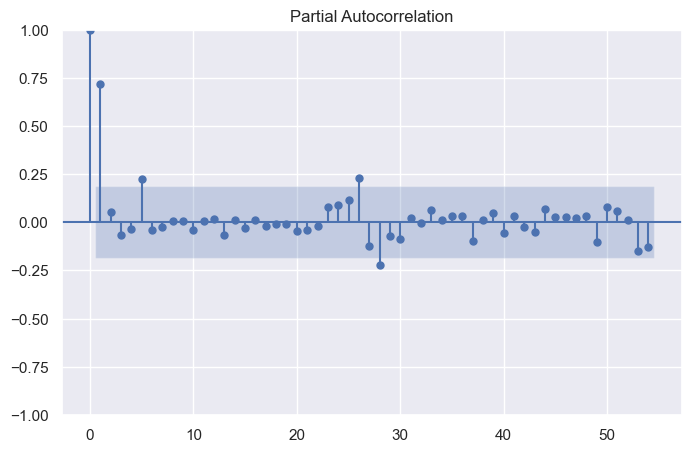

In [42]:
plot_pacf(train_ds['emission'].dropna(), lags = 54)
pyplot.show()

#### We see two spikes in the PACF plot. So we will consider AR(2). Our final model will be ARIMA(2,0,0)(2,1,0)53. 

In [43]:
# Seasonal ARIMA model
sarimax_model = SARIMAX(train_ds["emission"], order = (2, 0, 0), seasonal_order = (2, 1, 0, 53)).fit() # seasonal_order suggested by auto arima model
sarimax_model.summary()

C:\Users\chery\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                           emission   No. Observations:                  110
Model:             SARIMAX(2, 0, 0)x(2, 1, 0, 53)   Log Likelihood                -204.656
Date:                            Mon, 18 Nov 2024   AIC                            419.312
Time:                                    18:43:41   BIC                            429.527
Sample:                                         0   HQIC                           423.282
                                            - 110                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3607      0.054      6.742      0.000       0.256       0.466
ar.L2          0.5324      0.060      8.891      0.000       0.415       0.650
ar.S.L53      -0.8048     70.058     -0.011      0.991    -138.116     136.506
ar.S.L106      0.0020     87.226   2.32e-05      1.000    -170.958     170.962
sigma2        28.2316     53.836      0.524      0.600     -77.285     133.748
===================================================================================
Ljung-Box (L1) (Q):                   4.30   Jarque-Bera (JB):               134.66
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               0.14   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

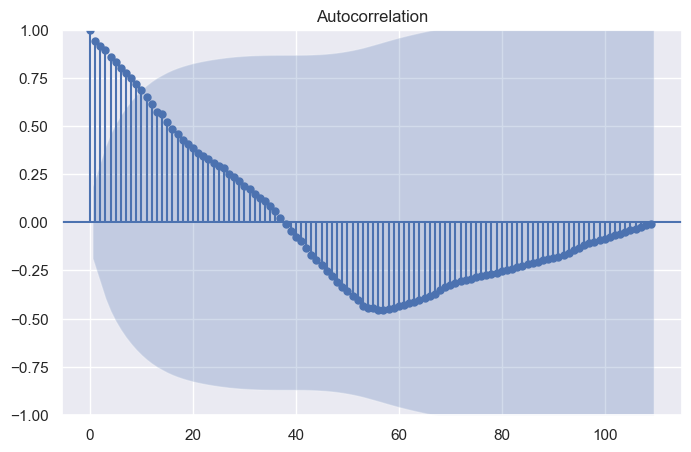

In [44]:
plot_acf(sarimax_model.resid, lags = 109)
pyplot.show()

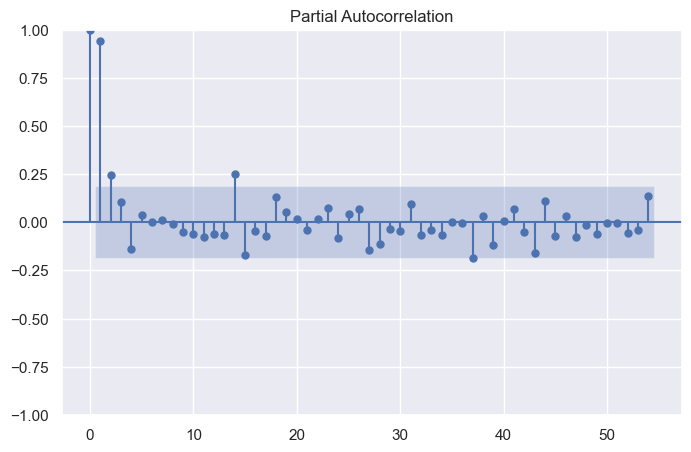

In [45]:
plot_pacf(sarimax_model.resid, lags = 54)
pyplot.show()

In [46]:
# Model 2: Seasonal ARIMA model
fcast_sarimax = sarimax_model.forecast(49)

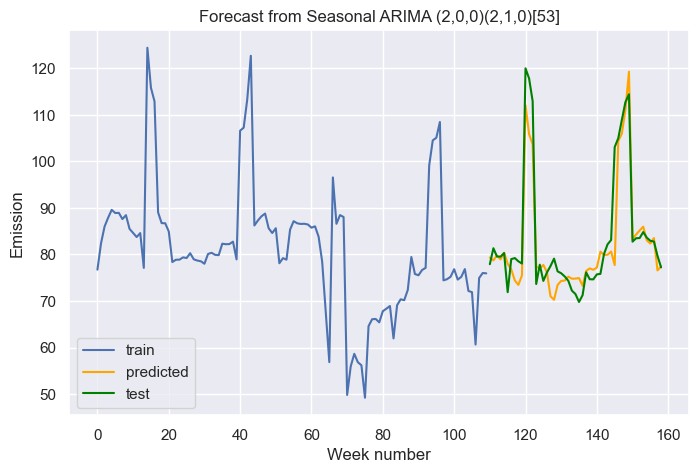

In [47]:
ax = train["emission"].plot(figsize=(8,5), label = "train")
fcast_sarimax.plot(ax = ax, color = "orange", title ='Forecast from Seasonal ARIMA (2,0,0)(2,1,0)[53]', label = "predicted")
plt.plot([x+110 for x in range(len(test["emission"]))], test["emission"], label = "test", color = "green")
plt.xlabel("Week number")
plt.ylabel("Emission")
plt.legend()
plt.show()

In [48]:
rmse_sarimax = sqrt(mean_squared_error(test['emission'], fcast_sarimax))
rmse_sarimax

5.242636745022917

#### Translating aggregate predictions into individual site predictions
We will take the ratio of aggregate to individual sites to get predictions for individual sites. 

In [49]:
train = train.drop('HWES_ADD', axis = 1)
train

,year,week_no,emission,emission_diff
0,2019,0,76.739149,NaN
1,2019,1,82.376350,NaN
2,2019,2,86.008823,NaN
3,2019,3,87.903964,NaN
4,2019,4,89.595095,NaN
...,...,...,...,...
105,2020,52,71.899535,-7.309258
106,2021,0,60.638294,-18.248272
107,2021,1,74.946603,-10.387763
108,2021,2,76.013958,-11.147352


In [50]:
# Select the train data that I designated from the whole dataset
train_df_big = df.loc[(df["year"] < 2021) | (df["week_no"] < 4)]
train_df_big

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,location_id,date,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.510,29.290,2019,0,-0.51_29.29,2019_0,-0.000108,0.603019,-0.000065,...,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.510,29.290,2019,1,-0.51_29.29,2019_1,0.000021,0.728214,0.000014,...,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.510,29.290,2019,2,-0.51_29.29,2019_2,0.000514,0.748199,0.000385,...,4216.986492,60068.894448,3516.282669,21.103410,0.251101,15.377883,30.401823,-142.519545,26.193296,4.231381
3,ID_-0.510_29.290_2019_03,-0.510,29.290,2019,3,-0.51_29.29,2019_3,NaN,NaN,NaN,...,5228.507736,51064.547339,4180.973322,15.386899,0.262043,-11.293399,24.380357,-132.665828,28.829155,4.305286
4,ID_-0.510_29.290_2019_04,-0.510,29.290,2019,4,-0.51_29.29,2019_4,-0.000079,0.676296,-0.000048,...,3980.598120,63751.125781,3355.710107,8.114694,0.235847,38.532263,37.392979,-141.509805,22.204612,4.347317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78969,ID_-3.299_30.301_2020_52,-3.299,30.301,2020,52,-3.299_30.301,2020_52,0.000025,1.103025,0.000028,...,5345.679464,62098.716546,4345.679397,13.082162,0.283677,-13.002957,38.243055,-136.660958,29.584058,25.559870
78970,ID_-3.299_30.301_2021_00,-3.299,30.301,2021,0,-3.299_30.301,2021_0,NaN,NaN,NaN,...,4314.458072,69007.504047,3314.458127,30.145029,0.284804,-12.523135,59.951177,-136.243401,30.893091,20.960030
78971,ID_-3.299_30.301_2021_01,-3.299,30.301,2021,1,-3.299_30.301,2021_1,NaN,NaN,NaN,...,5999.820620,58020.083143,5039.283874,20.322973,0.276521,-25.486430,40.850588,-136.439252,28.825398,25.804647
78972,ID_-3.299_30.301_2021_02,-3.299,30.301,2021,2,-3.299_30.301,2021_2,NaN,NaN,NaN,...,5386.144081,61417.954240,4420.581633,13.595422,0.287614,-0.277998,35.201400,-136.272137,27.099235,26.232119


In [51]:
# Find the average emission across all locations and time points.
avg_emission_wholedata = statistics.mean(train_df_big["emission"])
avg_emission_wholedata

81.26961151496619

In [52]:
# For each location, calculate the average emission. 
avg_emission_per_location = train_df_big.groupby(["location_id"])["emission"].mean().reset_index()
avg_emission_per_location.head()

,location_id,emission
0,-0.51_29.29,4.194490
1,-0.528_29.472,4.121992
2,-0.547_29.653,0.577721
3,-0.569_30.031,114.567304
4,-0.598_29.102,0.088491


In [53]:
avg_emission_per_location["site_ratio"] = avg_emission_per_location["emission"] / avg_emission_wholedata
avg_emission_per_location.head()

,location_id,emission,site_ratio
0,-0.51_29.29,4.194490,0.051612
1,-0.528_29.472,4.121992,0.050720
2,-0.547_29.653,0.577721,0.007109
3,-0.569_30.031,114.567304,1.409719
4,-0.598_29.102,0.088491,0.001089


In [54]:
print("Min site ratio:", min(avg_emission_per_location["site_ratio"]))
print("Max site ratio:", max(avg_emission_per_location["site_ratio"]))

Min site ratio: 0.0
Max site ratio: 26.925140810269493


In [55]:
len(avg_emission_per_location)

497

#### First location

In [56]:
test_firstlocation = df.head(159).tail(49) # Select a test set that covers from 2021 week 4 to 2021 week 52
test_firstlocation = test_firstlocation.reset_index()
test_firstlocation.head()

,index,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,location_id,date,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,...,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,110,ID_-0.510_29.290_2021_04,-0.51,29.29,2021,4,-0.51_29.29,2021_4,-0.000009,0.766009,...,5616.146900,59267.038012,4707.660364,7.747805,0.268286,-65.206115,45.831876,-132.634760,28.215139,4.161754
1,111,ID_-0.510_29.290_2021_05,-0.51,29.29,2021,5,-0.51_29.29,2021_5,0.000120,0.763368,...,6910.328195,52854.524933,5910.328209,14.699557,0.240911,0.049919,34.559715,-132.537165,24.766424,4.221930
2,112,ID_-0.510_29.290_2021_06,-0.51,29.29,2021,6,-0.51_29.29,2021_6,0.000340,0.745717,...,6066.192749,56536.817599,5066.192694,15.319441,0.236437,38.633854,40.245921,-136.010638,19.466343,4.178392
3,113,ID_-0.510_29.290_2021_07,-0.51,29.29,2021,7,-0.51_29.29,2021_7,NaN,NaN,...,7266.692229,49587.013269,6266.692229,41.491498,0.255918,-24.436467,42.123513,-120.869845,24.073775,4.149280
4,114,ID_-0.510_29.290_2021_08,-0.51,29.29,2021,8,-0.51_29.29,2021_8,0.000097,0.769636,...,7296.873242,49542.391406,6296.873193,8.909803,0.235352,4.258173,26.005385,-117.992003,19.454547,4.253003


In [57]:
# ESM prediction of first location for emissions from 2021 week 4 to 2021 week 52 (test set I created)
# Predicted emission
fcast_firstlocation = avg_emission_per_location["site_ratio"].iloc[0] * fcast_esm 
fcast_firstlocation = fcast_firstlocation.reset_index() 
fcast_firstlocation = fcast_firstlocation.rename(columns={0: 'emission'})
fcast_firstlocation.head()

,index,emission
0,110,3.996299
1,111,3.985102
2,112,3.987213
3,113,3.940524
4,114,3.975050


In [58]:
sqrt(mean_squared_error(test_firstlocation["emission"], fcast_firstlocation["emission"]))

0.9064857579515659

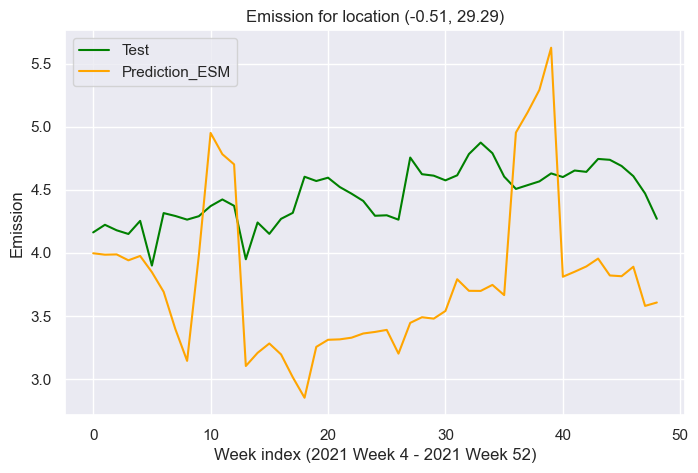

In [59]:
ax = test_firstlocation["emission"].plot(color = "green", figsize = (8, 5), title ='Emission for location (-0.51, 29.29)', label = "Test")
fcast_firstlocation["emission"].plot(ax = ax, color = "orange", label = "Prediction_ESM")
plt.xlabel("Week index (2021 Week 4 - 2021 Week 52)")
plt.ylabel("Emission")
plt.legend()
plt.show()

In [60]:
# Seasonal ARIMA prediction of first location for emissions from 2021 week 4 to 2021 week 52 (test set I created)
# Predicted emission
fcast_sarimax_firstlocation = avg_emission_per_location["site_ratio"].iloc[0] * fcast_sarimax 
fcast_sarimax_firstlocation = fcast_sarimax_firstlocation.reset_index() 
fcast_sarimax_firstlocation = fcast_sarimax_firstlocation.rename(columns={"predicted_mean": 'emission'})
fcast_sarimax_firstlocation.head()

,index,emission
0,110,4.094758
1,111,4.063550
2,112,4.118730
3,113,4.074628
4,114,4.148616


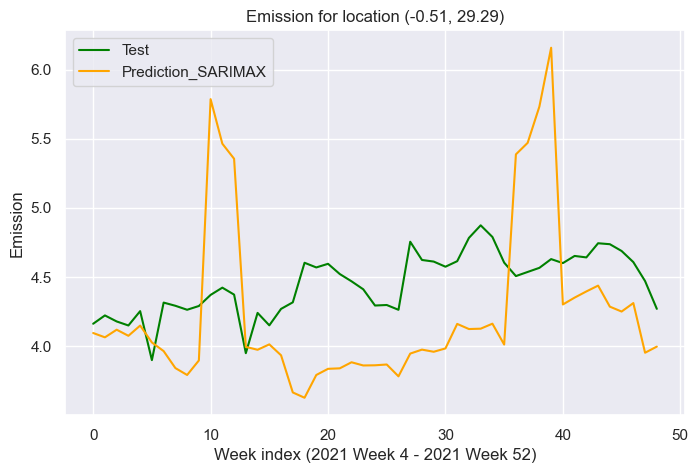

In [61]:
ax = test_firstlocation["emission"].plot(color = "green", figsize = (8, 5), title ='Emission for location (-0.51, 29.29)', label = "Test")
fcast_sarimax_firstlocation["emission"].plot(ax = ax, color = "orange", label = "Prediction_SARIMAX")
plt.xlabel("Week index (2021 Week 4 - 2021 Week 52)")
plt.ylabel("Emission")
plt.legend()
plt.show()

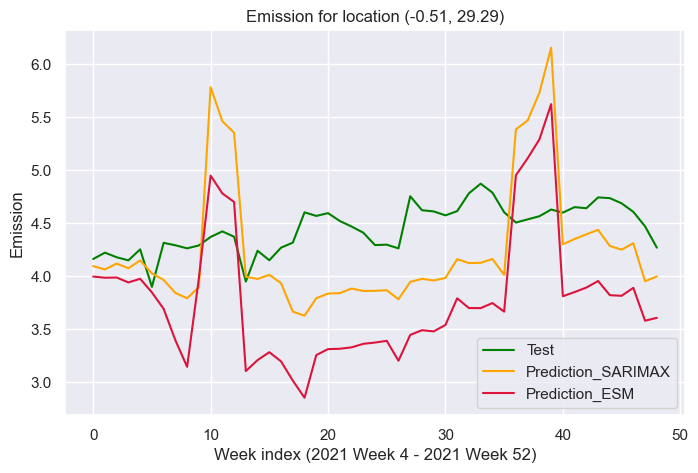

In [62]:
ax = test_firstlocation["emission"].plot(color = "green", figsize = (8, 5), title ='Emission for location (-0.51, 29.29)', label = "Test")
fcast_sarimax_firstlocation["emission"].plot(ax = ax, color = "orange", label = "Prediction_SARIMAX")
fcast_firstlocation["emission"].plot(ax = ax, color = "crimson", label = "Prediction_ESM")

plt.xlabel("Week index (2021 Week 4 - 2021 Week 52)")
plt.ylabel("Emission")
plt.legend()
plt.show()

#### RMSE comparison between ESM and SARIMAX models for location 1

In [63]:
# RMSE_ESM of location 1
rmse_esm_site1 = sqrt(mean_squared_error(test_firstlocation["emission"], fcast_firstlocation["emission"]))
rmse_esm_site1

0.9064857579515659

In [64]:
# RMSE_SARIMAX of location 1
rmse_sarimax_site1 = sqrt(mean_squared_error(test_firstlocation["emission"], fcast_sarimax_firstlocation["emission"]))
rmse_sarimax_site1 

0.632292916965731

------------------------------------
#### Approach 1: For each of the ESM and SARIMAX models, find the RMSE of sites 1-497, then average the RMSEs over all the sites. Use this average RMSE as the RMSE of each model. 

In [65]:
esm_rmse_vals = []
sarimax_rmse_vals = []

for i in range(0, len(df), 159): # Loop through df in chunks of 159 rows corresponding to one location.
    location = df.iloc[i:i+159]
    test_location = location.tail(49)  # The test set corresponding to that location
    
    j = i // 159 # Make a j index to loop through avg_emission_per_location one row at a time.
    assert j < len(avg_emission_per_location)
    
    esmfcast_location = avg_emission_per_location["site_ratio"].iloc[j] * fcast_esm   # ESM forecast for location[j]
    sarimaxfcast_location = avg_emission_per_location["site_ratio"].iloc[j] * fcast_sarimax   # SARIMAX forecast for location[j]
    esm_rmse_location = sqrt(mean_squared_error(test_location["emission"], esmfcast_location))  # RMSE from ESM forecast for location[j]
    sarimax_rmse_location = sqrt(mean_squared_error(test_location["emission"], sarimaxfcast_location))  # RMSE from SARIMAX forecast for location[j]
    esm_rmse_vals.append(esm_rmse_location)
    sarimax_rmse_vals.append(sarimax_rmse_location)


In [66]:
print("The average RMSE over all locations according to ESM model:", round(statistics.mean(esm_rmse_vals), 2))
print("The average RMSE over all locations according to SARIMAX model:", round(statistics.mean(sarimax_rmse_vals), 2))

The average RMSE over all locations according to ESM model: 61.83
The average RMSE over all locations according to SARIMAX model: 62.52


---------------------------------------------------
#### Examine patterns in missing values

In [67]:
# Drop ID_LAT_LON_YEAR_WEEK
df = df.drop("ID_LAT_LON_YEAR_WEEK", axis = 1)

In [68]:
# Ten variables that are most highly correlated with emission
top10_corrs

emission                                                    1.000000
UvAerosolLayerHeight_aerosol_height                         0.069008
UvAerosolLayerHeight_aerosol_pressure                       0.068138
Cloud_surface_albedo                                        0.046587
CarbonMonoxide_H2O_column_number_density                    0.043217
CarbonMonoxide_CO_column_number_density                     0.041328
Formaldehyde_tropospheric_HCHO_column_number_density_amf    0.040263
UvAerosolLayerHeight_aerosol_optical_depth                  0.040156
UvAerosolLayerHeight_sensor_azimuth_angle                   0.035142
NitrogenDioxide_solar_azimuth_angle                         0.033417
Name: emission, dtype: float64

In [69]:
# Pivot the DataFrame for each top 8 variable
pivot_uv_aerosolheight = df.pivot_table(index = ['year', 'week_no'], columns = 'location_id', values = 'UvAerosolLayerHeight_aerosol_height', dropna = False)
pivot_uv_aerosolpressure = df.pivot_table(index = ['year', 'week_no'], columns = 'location_id', values = 'UvAerosolLayerHeight_aerosol_pressure', dropna = False)
pivot_cloud = df.pivot_table(index = ['year', 'week_no'], columns = 'location_id', values = 'Cloud_surface_albedo', dropna = False)
pivot_CO1_H20density = df.pivot_table(index = ['year', 'week_no'], columns = 'location_id', values = 'CarbonMonoxide_H2O_column_number_density', dropna = False) 
pivot_CO1_COdensity = df.pivot_table(index = ['year', 'week_no'], columns = 'location_id', values = 'CarbonMonoxide_CO_column_number_density', dropna = False)
pivot_formaldehyde = df.pivot_table(index = ['year', 'week_no'], columns = 'location_id', values = 'Formaldehyde_tropospheric_HCHO_column_number_density_amf', dropna = False)
pivot_uv_aerosolopticaldepth = df.pivot_table(index = ['year', 'week_no'], columns = 'location_id', values = 'UvAerosolLayerHeight_aerosol_optical_depth', dropna = False)
pivot_uv_sensorazimuth = df.pivot_table(index = ['year', 'week_no'], columns = 'location_id', values = 'UvAerosolLayerHeight_sensor_azimuth_angle', dropna = False)

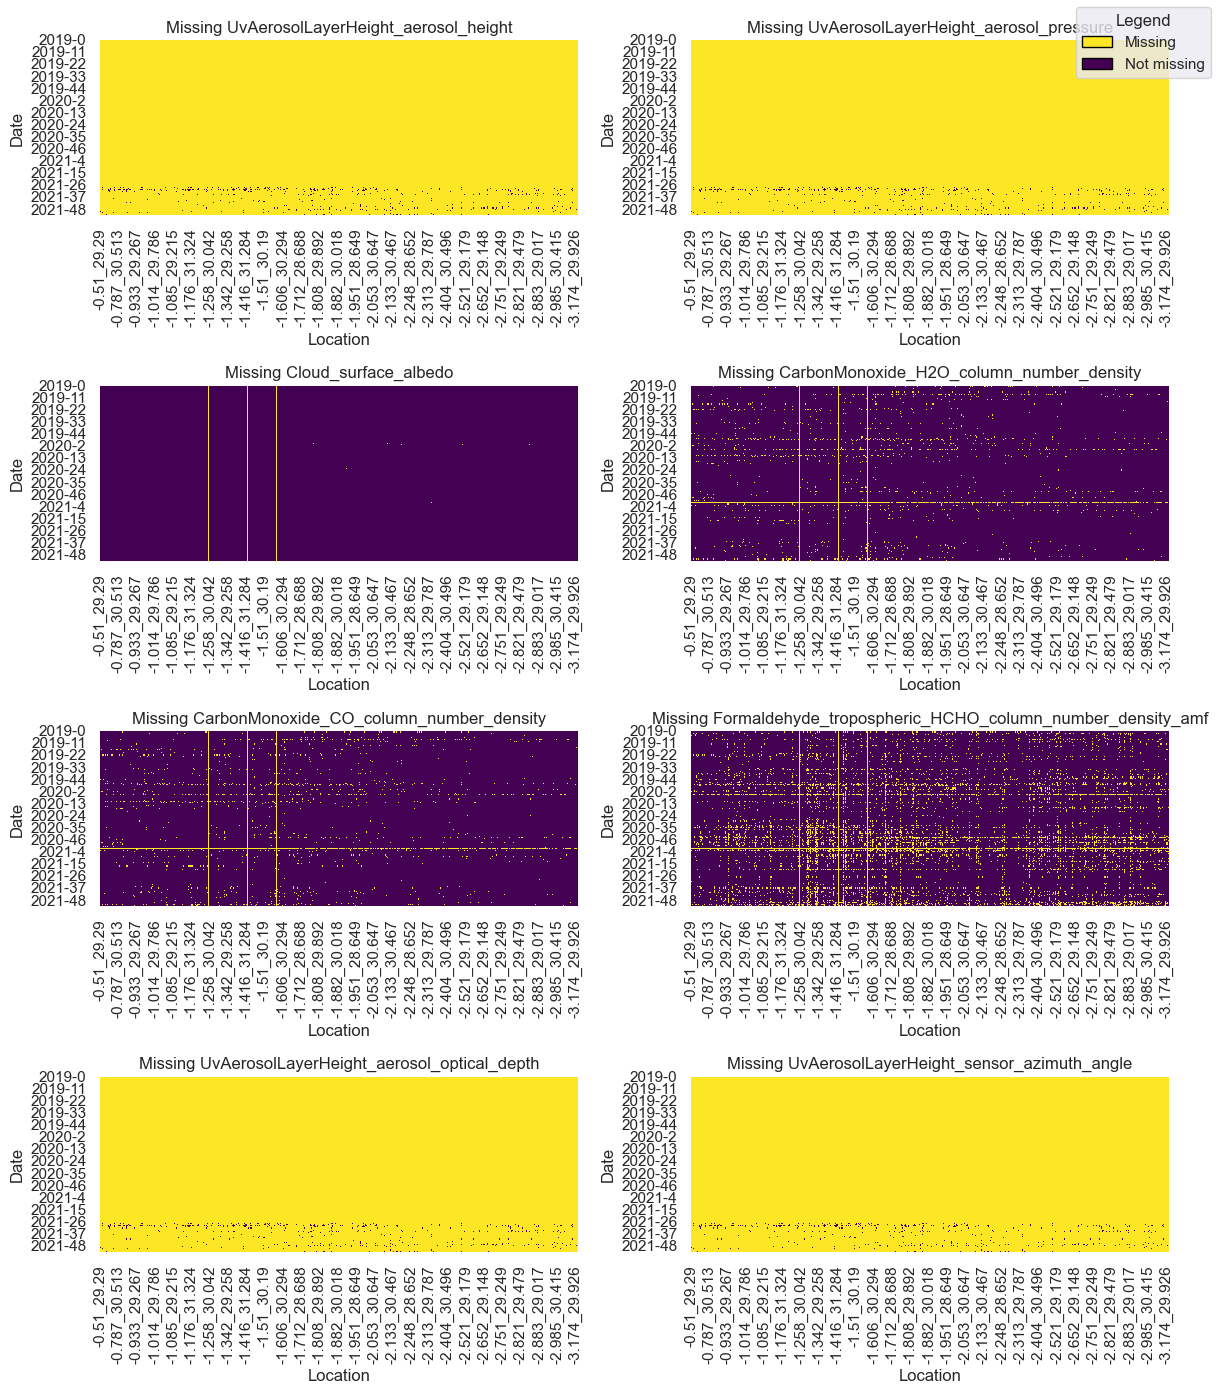

In [70]:
# Create subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 14))
cmap = plt.get_cmap('viridis')

# Plot heatmaps
sns.heatmap(pivot_uv_aerosolheight.isnull(), cbar=False, cmap=cmap, ax=axes[0][0])
axes[0][0].set_title('Missing UvAerosolLayerHeight_aerosol_height')
axes[0][0].set_xlabel('Location')
axes[0][0].set_ylabel('Date')

sns.heatmap(pivot_uv_aerosolpressure.isnull(), cbar=False, cmap=cmap, ax=axes[0][1])
axes[0][1].set_title('Missing UvAerosolLayerHeight_aerosol_pressure')
axes[0][1].set_xlabel('Location')
axes[0][1].set_ylabel('Date')

sns.heatmap(pivot_cloud.isnull(), cbar=False, cmap=cmap, ax=axes[1][0])
axes[1][0].set_title('Missing Cloud_surface_albedo')
axes[1][0].set_xlabel('Location')
axes[1][0].set_ylabel('Date')

sns.heatmap(pivot_CO1_H20density.isnull(), cbar=False, cmap=cmap, ax=axes[1][1])
axes[1][1].set_title('Missing CarbonMonoxide_H2O_column_number_density')
axes[1][1].set_xlabel('Location')
axes[1][1].set_ylabel('Date')

sns.heatmap(pivot_CO1_COdensity.isnull(), cbar=False, cmap=cmap, ax=axes[2][0])
axes[2][0].set_title('Missing CarbonMonoxide_CO_column_number_density')
axes[2][0].set_xlabel('Location')
axes[2][0].set_ylabel('Date')

sns.heatmap(pivot_formaldehyde.isnull(), cbar=False, cmap=cmap, ax=axes[2][1])
axes[2][1].set_title('Missing Formaldehyde_tropospheric_HCHO_column_number_density_amf')
axes[2][1].set_xlabel('Location')
axes[2][1].set_ylabel('Date')

sns.heatmap(pivot_uv_aerosolopticaldepth.isnull(), cbar=False, cmap=cmap, ax=axes[3][0])
axes[3][0].set_title('Missing UvAerosolLayerHeight_aerosol_optical_depth')
axes[3][0].set_xlabel('Location')
axes[3][0].set_ylabel('Date')

sns.heatmap(pivot_uv_sensorazimuth.isnull(), cbar=False, cmap=cmap, ax=axes[3][1])
axes[3][1].set_title('Missing UvAerosolLayerHeight_sensor_azimuth_angle')
axes[3][1].set_xlabel('Location')
axes[3][1].set_ylabel('Date')

# Create custom legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=cmap(1.0), edgecolor='black', label='Missing'),
                   Patch(facecolor=cmap(0.0), edgecolor='black', label='Not missing')]

# Add legend to the figure
fig.legend(handles=legend_elements, loc='upper right', title='Legend')

# Adjust layout
plt.tight_layout()
plt.show()